In [ ]:
# PARTE 1: DESCARGA Y PREPARACIÓN DEL DATASET

# Librerías
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# DESCARGA DEL DATASET DESDE KAGGLEHUB

import kagglehub
import os

try:
    # Descargar el dataset
    path = kagglehub.dataset_download("feyzazkefe/trashnet")
    print(f" Dataset descargado correctamente en:\n{path}")

    # Verificar estructura
    print("\n Contenido del dataset:")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")
except Exception as e:
    print(f" Error al descargar el dataset: {e}")


100%|██████████| 40.8M/40.8M [00:00<00:00, 133MB/s]

Extracting files...


 Dataset descargado correctamente en:
/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1

 Contenido del dataset:
1/
    dataset-resized/
        trash/
            trash84.jpg
            trash13.jpg
            trash133.jpg
            trash57.jpg
            trash64.jpg
            trash6.jpg
            trash59.jpg
            trash101.jpg
            trash4.jpg
            trash50.jpg
            trash3.jpg
            trash107.jpg
            trash126.jpg
            trash118.jpg
            trash19.jpg
            trash32.jpg
            trash104.jpg
            trash134.jpg
            trash58.jpg
            trash49.jpg
            trash52.jpg
            trash119.jpg
            trash24.jpg
            trash29.jpg
            trash82.jpg
            trash34.jpg
            trash41.jpg
            trash83.jpg
            trash73.jpg
            trash60.jpg
            trash91.jpg
            trash93.jpg
            trash97.jpg
            trash33.jpg
            tr

In [ ]:
# PARTE 2: CREACIÓN DE GENERADORES DE IMÁGENES

import os

base_dir = "/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized"

if not os.path.exists(base_dir):
    print(f"Error: El directorio base '{base_dir}' no existe. Por favor, verifica la ruta.")
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="training"
    )

    val_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="validation"
    )

    print("Clases detectadas:", train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Clases detectadas: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
# PARTE 3: MODELO CNN PARA CLASIFICACIÓN DE RESIDUOS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir la arquitectura de la CNN
model = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Clasificador
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
model.summary()

# ENTRENAMIENTO DEL MODELO

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,310 (12.61 MB)

 Trainable params: 3,305,862 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 313ms/step - accuracy: 0.3753 - loss: 2.4598 - val_accuracy: 0.0736 - val_loss: 2.5625
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5591 - loss: 1.2377 - val_accuracy: 0.1034 - val_loss: 3.5213
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.5773 - loss: 1.1997 - val_accuracy: 0.1909 - val_loss: 2.9260
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.6147 - loss: 1.0612 - val_accuracy: 0.2207 - val_loss: 2.9676
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.6311 - loss: 0.9988 - val_accuracy: 0.2763 - val_loss: 1.9312
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.6348 - loss: 1.0064 - val_accuracy: 0.3718 - val_loss: 1.6736
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.6316 - loss: 0.9547 - val_accuracy: 0.4632 - val_loss: 1.4135
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.6635 - loss: 0.9368 - val_accu

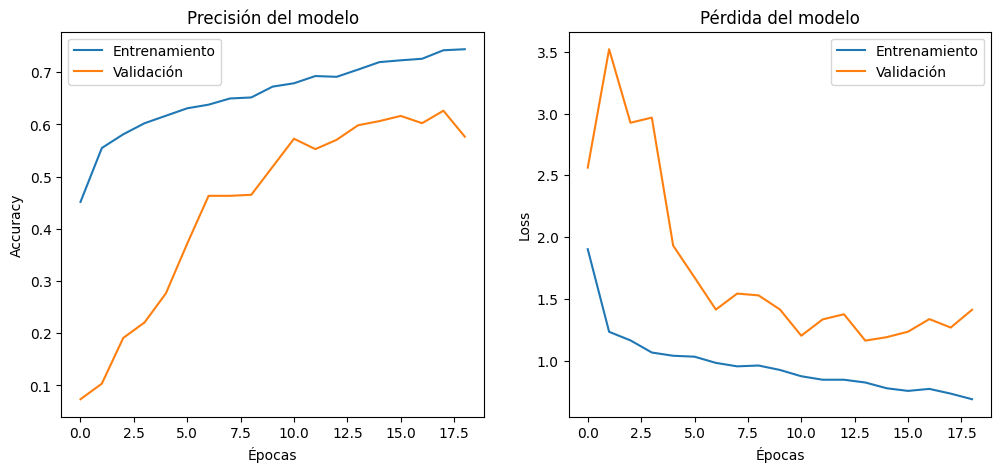

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6465 - loss: 1.0683

Precisión final en validación: 60.83%


In [ ]:
# PARTE 4: EVALUACIÓN Y VISUALIZACIÓN

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nPrecisión final en validación: {val_acc:.2%}")
